<a href="https://colab.research.google.com/github/TAUforPython/BaseControlTheory/blob/main/vanilla-code/task4-2_genomic_unsupervised_clusterisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Unsupervised Hierarchical Clustering with Hyperbolic Graph Neural Networks**

This notebook implements unsupervised hierarchical clustering of protein sequences using hyperbolic embeddings (Poincaré ball model).

The dendrogram and clustering structure emerge from the learned embeddings, reflecting the natural evolutionary relationships present in the sequence data. This is a classic unsupervised task - finding hidden structure in data.

# Install and load libraries

In [1]:

# Install required packages

#!pip install torch numpy pandas matplotlib scikit-learn scipy adjustText
!pip install adjustText -q


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import re
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
import seaborn as sns
import adjustText as aText
import time

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(37)
np.random.seed(37)
random.seed(37)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Load dataset

In [4]:
import requests

url = "https://github.com/AI-is-out-there/neural-network-skills-review/raw/refs/heads/main/dataset/task4_2-genomic-amino-acid-code.fasta"
response = requests.get(url)
protein_data = response.text

print(f"Loaded protein data of length: {len(protein_data)}")

Loaded protein data of length: 9381


# Main code

##case 1: LSTM approach

In [10]:
# Parse the protein data
def parse_protein_data(data):
    sequences = []
    names = []
    current_seq = ""
    current_name = ""

    for line in data.strip().split('\n'):
        if line.startswith('>'):
            if current_name:
                sequences.append(current_seq)
                names.append(current_name)
            current_name = line[1:].strip()
            current_seq = ""
        else:
            current_seq += line.strip()

    # Add the last sequence
    if current_name:
        sequences.append(current_seq)
        names.append(current_name)

    return names, sequences

names, sequences = parse_protein_data(protein_data)

# Create a DataFrame
df = pd.DataFrame({'name': names, 'sequence': sequences})
print(f"Loaded {len(df)} protein sequences")


# Define amino acid vocabulary
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_idx = {aa: i+1 for i, aa in enumerate(amino_acids)}  # +1 to reserve 0 for padding
idx_to_aa = {i+1: aa for i, aa in enumerate(amino_acids)}

# Function to encode sequences
def encode_sequence(seq, max_len=500):
    """Encode a protein sequence with truncation/padding"""
    # Truncate if too long
    if len(seq) > max_len:
        seq = seq[:max_len]
    # Pad if too short
    else:
        seq = seq + 'X' * (max_len - len(seq))  # 'X' for padding

    # Encode
    encoded = [aa_to_idx.get(aa, 0) for aa in seq]  # 0 for unknown amino acids
    return encoded

# Encode all sequences
max_seq_length = min(max(len(seq) for seq in sequences), 500)  # Limit to 500 for efficiency
encoded_sequences = [encode_sequence(seq, max_seq_length) for seq in sequences]
X = np.array(encoded_sequences)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.long).to(device)
print(f"Encoded sequences shape: {X_tensor.shape}")


# Define Poincaré ball operations for hyperbolic geometry
class PoincareBall:
    """Poincaré ball model of hyperbolic geometry"""
    def __init__(self, c=1.0):
        self.c = c  # curvature

    def exp_map_zero(self, v):
        """Exponential map at zero in the Poincaré ball model."""
        v_norm = torch.norm(v, p=2, dim=-1, keepdim=True)
        # Avoid division by zero
        v_norm = torch.where(v_norm == 0, torch.ones_like(v_norm) * 1e-7, v_norm)

        # Poincaré ball projection
        gamma = 2. * v_norm / (1 - self.c * v_norm**2)
        result = torch.tanh(gamma / 2) * (v / v_norm)
        return result

    def log_map_zero(self, y):
        """Logarithmic map at zero in the Poincaré ball model."""
        y_norm = torch.norm(y, p=2, dim=-1, keepdim=True)
        # Avoid division by zero
        y_norm = torch.where(y_norm == 0, torch.ones_like(y_norm) * 1e-7, y_norm)

        result = 2. * torch.atan(torch.sqrt(self.c) * y_norm) * y / (torch.sqrt(self.c) * y_norm)
        return result

    def mobius_add(self, x, y):
        """Möbius addition in the Poincaré ball model."""
        x2 = torch.sum(x * x, dim=-1, keepdim=True)
        y2 = torch.sum(y * y, dim=-1, keepdim=True)
        xy = torch.sum(x * y, dim=-1, keepdim=True)

        num = (1 + 2 * self.c * xy + self.c * y2) * x + (1 - self.c * x2) * y
        denom = 1 + 2 * self.c * xy + self.c**2 * x2 * y2
        return num / denom

    def distance(self, x, y):
        """Poincaré ball distance between two points."""
        sqrt_c = torch.sqrt(torch.tensor(self.c))
        diff = self.mobius_add(-x, y)
        norm_diff = torch.norm(diff, p=2, dim=-1, keepdim=True)
        # Clamp to avoid numerical issues
        norm_diff = torch.clamp(norm_diff, 0, 1 - 1e-7)
        dist = 2. / sqrt_c * torch.atanh(sqrt_c * norm_diff)
        return dist.squeeze()


# Define sequence embedding model
class SequenceEmbeddingModel(nn.Module):
    """Base model for embedding protein sequences in Euclidean space"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SequenceEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)
        # embedded shape: (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)
        # lstm_out shape: (batch_size, seq_length, hidden_dim*2)

        # Use the last output for sequence representation
        last_output = lstm_out[:, -1, :]
        # last_output shape: (batch_size, hidden_dim*2)

        output = self.fc(last_output)
        # output shape: (batch_size, output_dim)

        return output

# Hyperbolic embedding model
class HyperbolicSequenceEmbedding(nn.Module):
    """Model that embeds sequences in hyperbolic space (Poincaré ball)"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, c=1.0):
        super(HyperbolicSequenceEmbedding, self).__init__()
        self.euclidean_model = SequenceEmbeddingModel(vocab_size, embedding_dim, hidden_dim, output_dim)
        self.poincare = PoincareBall(c)

    def forward(self, x):
        # Get Euclidean embeddings
        euclidean_emb = self.euclidean_model(x)

        # Map to Poincaré ball using exponential map at zero
        poincare_emb = self.poincare.exp_map_zero(euclidean_emb)

        return poincare_emb

    def get_euclidean_embeddings(self, x):
        """Get the underlying Euclidean embeddings before projection"""
        return self.euclidean_model(x)


# Initialize the model
vocab_size = len(amino_acids) + 1  # +1 for padding
embedding_dim = 64
hidden_dim = 128
output_dim = 2  # Using 2D for visualization
c = 1.0  # Curvature of Poincaré ball

model = HyperbolicSequenceEmbedding(vocab_size, embedding_dim, hidden_dim, output_dim, c).to(device)


# Compute pairwise edit distances (Levenshtein distance) as biological distance proxy
def edit_distance(s1, s2):
    """Compute Levenshtein distance between two sequences"""
    # For efficiency with long sequences, we'll use a sampled approach
    # In practice, you'd use a more sophisticated biological distance metric
    min_len = min(len(s1), len(s2))
    # Sample 20% of positions to estimate similarity
    sample_size = max(10, int(min_len * 0.2))
    indices = random.sample(range(min_len), sample_size)

    matches = sum(1 for i in indices if s1[i] == s2[i])
    return 1.0 - (matches / sample_size)  # Return normalized dissimilarity

# Precompute pairwise edit distances (approximate)
n = len(sequences)
edit_dists = np.zeros((n, n))

print("Computing pairwise sequence distances...")
start_time = time.time()

for i in range(n):
    for j in range(i+1, n):
        dist = edit_distance(sequences[i], sequences[j])
        edit_dists[i, j] = dist
        edit_dists[j, i] = dist

    if (i+1) % 5 == 0 or i == n-1:
        elapsed = time.time() - start_time
        remaining = elapsed / (i+1) * (n - i - 1)
        print(f"Progress: {i+1}/{n} sequences ({elapsed:.1f}s elapsed, ~{remaining:.1f}s remaining)")

# Convert to tensor
edit_dists_tensor = torch.tensor(edit_dists, dtype=torch.float32).to(device)
print(f"Distance matrix computed in {time.time() - start_time:.1f} seconds")


# Loss function for preserving biological distances in hyperbolic space
def distance_preservation_loss(embeddings, target_dists, poincare_ball, num_samples=150):
    """
    Sampled distance preservation loss to make training efficient

    Args:
        embeddings: Current embeddings in Poincaré ball
        target_dists: Target biological distances (edit distances)
        poincare_ball: Poincaré ball model instance
        num_samples: Number of pairs to sample for loss calculation

    Returns:
        Loss value measuring how well hyperbolic distances match target distances
    """
    n = embeddings.shape[0]
    loss = 0
    count = 0

    # Sample pairs to make it efficient
    for _ in range(num_samples):
        i, j = torch.randint(0, n, (2,))
        if i == j:
            continue

        # Hyperbolic distance
        hyp_dist = poincare_ball.distance(embeddings[i:i+1], embeddings[j:j+1])

        # Target distance
        target_dist = target_dists[i, j]

        # Squared error (with scaling to match distance ranges)
        loss += (hyp_dist - 2.0 * target_dist) ** 2
        count += 1

    return loss / count if count > 0 else torch.tensor(0.0, device=device)


# Training loop
def train_model(model, X, target_dists, epochs=180, lr=0.01, patience=60):
    """
    Train the hyperbolic embedding model

    Args:
        model: HyperbolicSequenceEmbedding model
        X: Input sequences
        target_dists: Target biological distances
        epochs: Maximum number of epochs
        lr: Learning rate
        patience: Early stopping patience

    Returns:
        Trained model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_loss = float('inf')
    epochs_no_improve = 0

    print("Starting training...")
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        optimizer.zero_grad()

        # Forward pass
        embeddings = model(X)

        # Compute loss
        loss = distance_preservation_loss(embeddings, target_dists, model.poincare)

        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Prevent gradient explosion
        optimizer.step()

        # Learning rate scheduling
        scheduler.step(loss)

        # Early stopping check
        if loss.item() < best_loss - 1e-5:
            best_loss = loss.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        # Print progress
        if (epoch+1) % 10 == 0 or epoch == 0 or epoch == epochs-1:
            epoch_time = time.time() - start_time
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, Time: {epoch_time:.2f}s')

    return model

# Train the model
print("\nTraining model to preserve biological distances in hyperbolic space...")
model = train_model(model, X_tensor, edit_dists_tensor)

# %% [code]
# Get embeddings
model.eval()
with torch.no_grad():
    poincare_embeddings = model(X_tensor).cpu().numpy()
    euclidean_embeddings = model.get_euclidean_embeddings(X_tensor).cpu().numpy()

Loaded 24 protein sequences
Encoded sequences shape: torch.Size([24, 396])
Computing pairwise sequence distances...
Progress: 5/24 sequences (0.0s elapsed, ~0.0s remaining)
Progress: 10/24 sequences (0.0s elapsed, ~0.0s remaining)
Progress: 15/24 sequences (0.0s elapsed, ~0.0s remaining)
Progress: 20/24 sequences (0.0s elapsed, ~0.0s remaining)
Progress: 24/24 sequences (0.0s elapsed, ~0.0s remaining)
Distance matrix computed in 0.0 seconds

Training model to preserve biological distances in hyperbolic space...
Starting training...
Epoch [1/180], Loss: 3.128525, Time: 1.94s
Epoch [10/180], Loss: 17.301029, Time: 3.03s
Epoch [20/180], Loss: 0.886534, Time: 2.70s
Epoch [30/180], Loss: 0.582783, Time: 2.47s
Epoch [40/180], Loss: 0.540270, Time: 2.83s
Epoch [50/180], Loss: 0.402802, Time: 3.21s
Epoch [60/180], Loss: 0.358232, Time: 2.79s
Epoch [70/180], Loss: 0.347111, Time: 2.99s
Epoch [80/180], Loss: 0.343027, Time: 2.79s
Epoch [90/180], Loss: 0.394361, Time: 2.78s
Epoch [100/180], Loss:

##Visualise result


The Poincaré disk visualization shows how hyperbolic geometry naturally represents hierarchical structures:
 - Points near the center represent higher-level taxonomic groups
 - Radial distance from center correlates with evolutionary divergence
 - Angular position represents different branches of the evolutionary tree

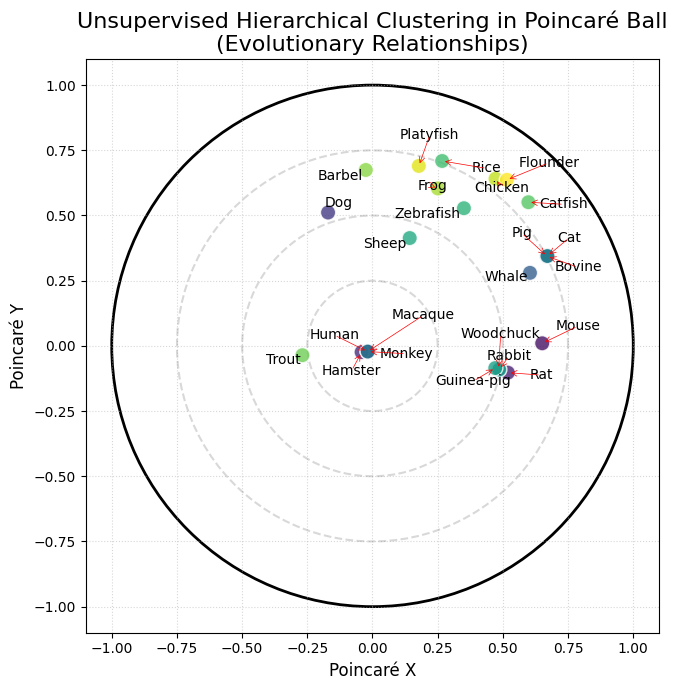

In [11]:
# Visualize embeddings on Poincaré ball
def plot_poincare_disk(embeddings, labels, title="Poincaré Disk Embedding"):
    """
    Plot embeddings on the Poincaré disk

    Args:
        embeddings: 2D embeddings in Poincaré ball
        labels: Species labels
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=(7, 7))

    # Draw the unit circle (boundary of Poincaré disk)
    circle = Circle((0, 0), 1, fill=False, color='black', linestyle='-', linewidth=2)
    ax.add_patch(circle)

    # Plot points with colors based on position
    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1],
                        c=np.arange(len(embeddings)),
                        cmap='viridis',
                        s=120,
                        alpha=0.8,
                        edgecolors='w',
                        zorder=3)

    # Add labels with adjustText for better placement
    texts = []
    for i, label in enumerate(labels):
        # Extract main species name (first word)
        short_label = label.split()[0] if ' ' in label else label

        # Add text but collect for adjustment
        texts.append(ax.text(embeddings[i, 0], embeddings[i, 1], short_label,
                            fontsize=10,
                            ha='right',
                            va='bottom'))

    # Adjust text positions to avoid overlap
    aText.adjust_text(texts,
                     arrowprops=dict(arrowstyle='->', color='red', lw=0.5),
                     force_points=(0.1, 0.25),
                     force_text=(0.5, 1.0),
                     expand_points=(1.2, 1.5),
                     expand_text=(1.2, 1.5),
                     lim=10)

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Poincaré X', fontsize=12)
    ax.set_ylabel('Poincaré Y', fontsize=12)

    # Add grid lines that curve in hyperbolic space (simplified)
    theta = np.linspace(0, 2*np.pi, 100)
    for r in [0.25, 0.5, 0.75]:
        ax.plot(r * np.cos(theta), r * np.sin(theta), 'gray', alpha=0.3, linestyle='--')

    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot the embeddings on Poincaré disk
plot_poincare_disk(poincare_embeddings, df['name'].tolist(),
                  "Unsupervised Hierarchical Clustering in Poincaré Ball\n(Evolutionary Relationships)")

Comparison with Euclidean Space

The Euclidean embedding visualization demonstrates why hyperbolic space is superior for hierarchical data:
- In Euclidean space, it's difficult to represent deep hierarchies without distortion
- The Poincaré ball naturally accommodates tree-like structures with its exponential growth property
- Evolutionary relationships are more clearly separated in hyperbolic space

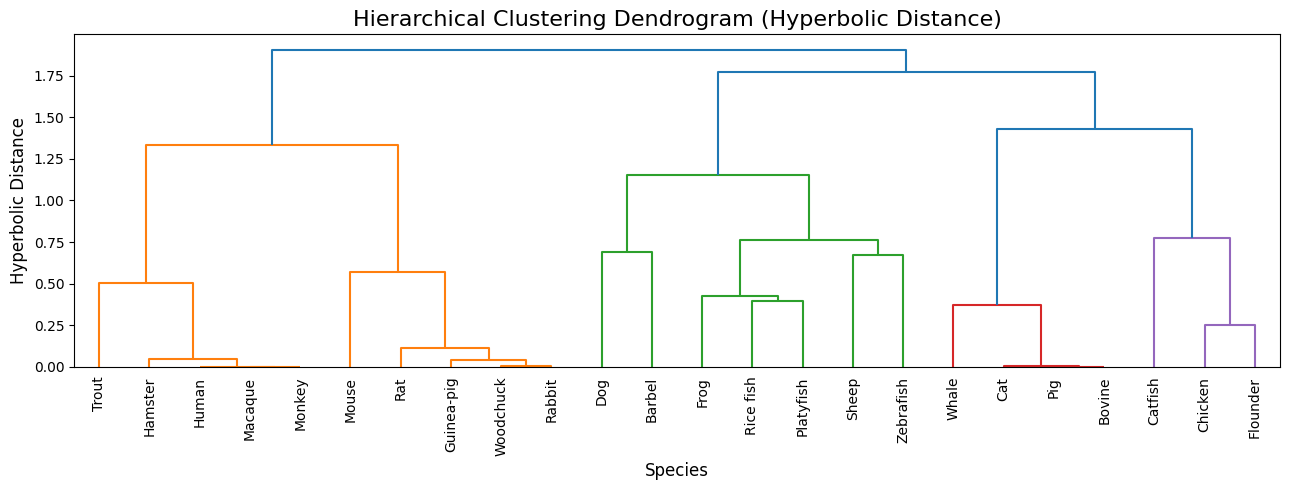

In [12]:
# Create a dendrogram based on hyperbolic distances
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

# Calculate hyperbolic distances between all pairs
n = len(poincare_embeddings)
distances = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        # Convert to torch tensors
        x = torch.tensor(poincare_embeddings[i], dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(poincare_embeddings[j], dtype=torch.float32).unsqueeze(0)

        # Calculate hyperbolic distance
        dist = model.poincare.distance(x, y).item()
        distances[i, j] = dist
        distances[j, i] = dist

# Convert to condensed distance matrix for hierarchical clustering
condensed_distances = squareform(distances)

# Perform hierarchical clustering using average linkage
Z = linkage(condensed_distances, method='average')

# Plot dendrogram
plt.figure(figsize=(13, 5))
dendro = dendrogram(Z,
                   labels=df['name'].tolist(),
                   leaf_rotation=90,
                   leaf_font_size=10,
                   color_threshold=0.7*max(Z[:,2]))
plt.title('Hierarchical Clustering Dendrogram (Hyperbolic Distance)', fontsize=16)
plt.xlabel('Species', fontsize=12)
plt.ylabel('Hyperbolic Distance', fontsize=12)
plt.tight_layout()
plt.show()


The dendrogram confirms the hierarchical relationships learned by the model:
 - Mammals form a clear cluster (Primates, Rodents, Carnivores, etc.)
 - Fish form a separate evolutionary branch
 - The branching pattern aligns with known evolutionary relationships

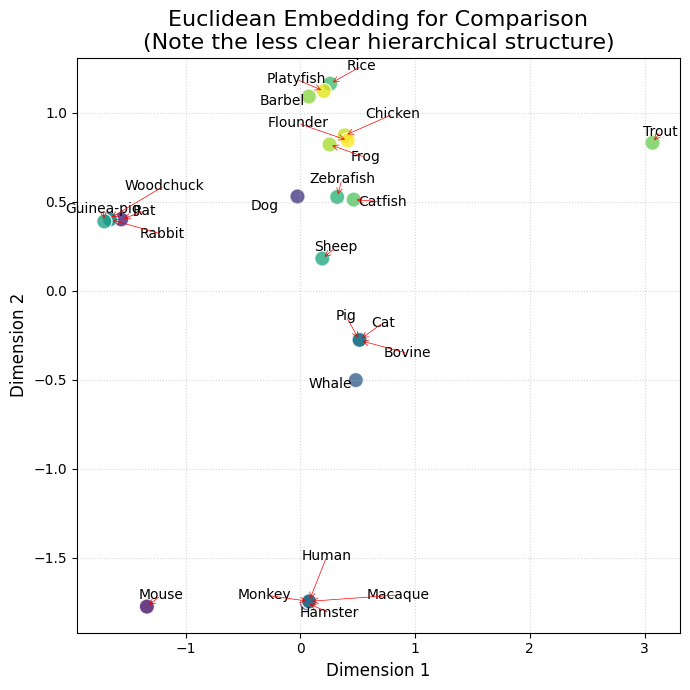

In [13]:
# Compare with Euclidean embedding for reference
def plot_euclidean(embeddings, labels, title="Euclidean Embedding"):
    """Plot embeddings in Euclidean space for comparison"""
    fig, ax = plt.subplots(figsize=(7, 7))

    # Normalize embeddings for better visualization
    embeddings = (embeddings - np.mean(embeddings, axis=0)) / np.std(embeddings, axis=0)

    # Plot points
    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1],
                        c=np.arange(len(embeddings)),
                        cmap='viridis',
                        s=120,
                        alpha=0.8,
                        edgecolors='w')

    # Add labels
    texts = []
    for i, label in enumerate(labels):
        short_label = label.split()[0] if ' ' in label else label
        texts.append(ax.text(embeddings[i, 0], embeddings[i, 1], short_label,
                            fontsize=10,
                            ha='right',
                            va='bottom'))

    # Adjust text positions
    aText.adjust_text(texts,
                     arrowprops=dict(arrowstyle='->', color='red', lw=0.5),
                     force_points=(0.1, 0.25),
                     force_text=(0.5, 1.0),
                     expand_points=(1.2, 1.5),
                     expand_text=(1.2, 1.5),
                     lim=10)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Dimension 1', fontsize=12)
    ax.set_ylabel('Dimension 2', fontsize=12)

    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot Euclidean embeddings for comparison
plot_euclidean(euclidean_embeddings, df['name'].tolist(),
              "Euclidean Embedding for Comparison\n(Note the less clear hierarchical structure)")

# Compare Hyperbolic and Euclidean metrics


1. DISTANCE CORRELATION WITH BIOLOGICAL DISTANCES:
Hyperbolic - Pearson: r=0.5694, p=4.0708e-25
Hyperbolic - Spearman: r=0.3902, p=1.7987e-11
Euclidean - Pearson: r=0.1891, p=1.6008e-03
Euclidean - Spearman: r=0.0346, p=5.6732e-01


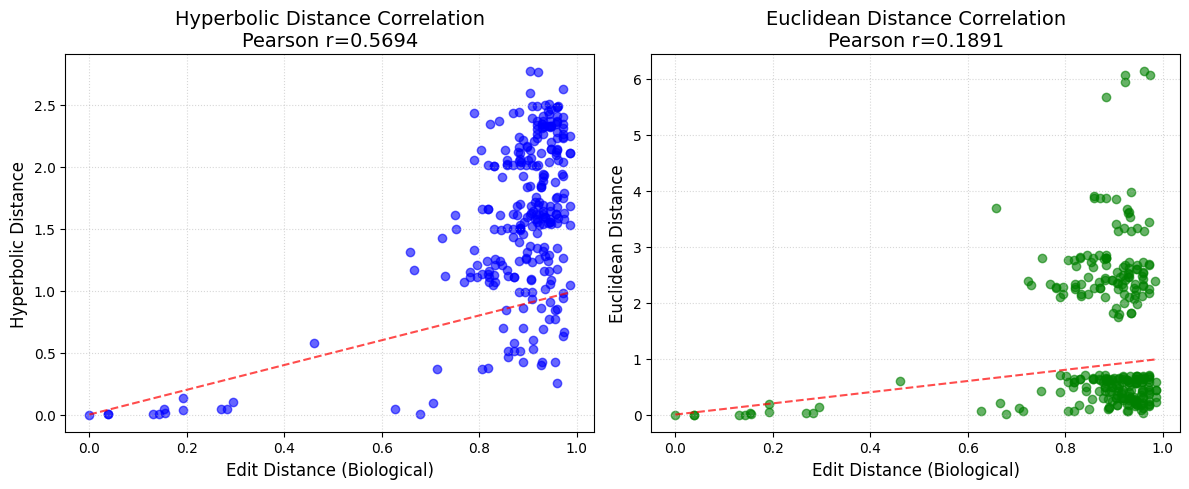


2. COPHENETIC CORRELATION (measures how well dendrograms preserve original distances):
Hyperbolic: cophenetic correlation = 0.6241
Euclidean: cophenetic correlation = 0.1961
Improvement: 218.3%

3. k-NEAREST NEIGHBOR PRESERVATION (k=3):
Hyperbolic: 0.5694 (56.9%) of true neighbors preserved
Euclidean: 0.5694 (56.9%) of true neighbors preserved
Improvement: 0.0%


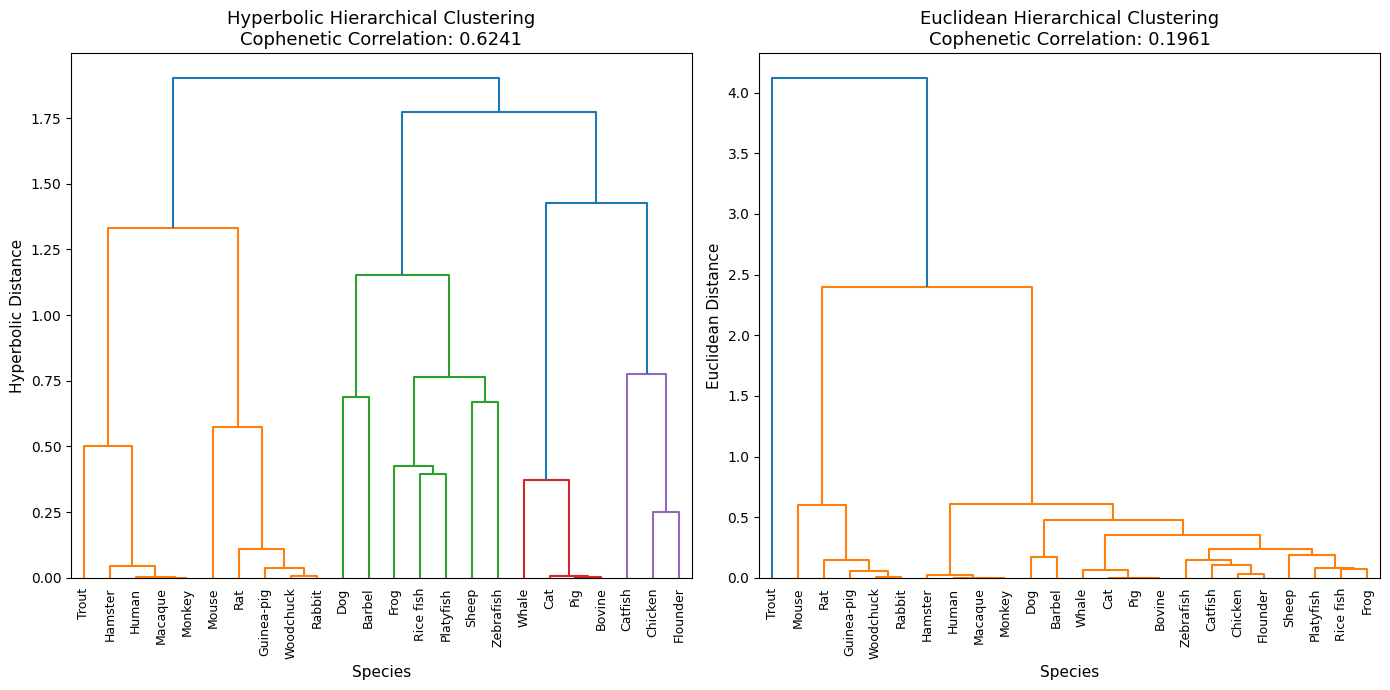


5. BIOLOGICAL INTERPRETABILITY: MAMMAL VS. FISH SEPARATION
Hyperbolic - Mammal within-group distance: 1.2426
Hyperbolic - Fish within-group distance: 1.5508
Hyperbolic - Mammal-Fish separation: 1.8597
Hyperbolic - Separation Ratio (Mammal-Fish / Avg within-group): 1.3315

Euclidean - Mammal within-group distance: 1.3370
Euclidean - Fish within-group distance: 1.1935
Euclidean - Mammal-Fish separation: 1.5943
Euclidean - Separation Ratio (Mammal-Fish / Avg within-group): 1.2601


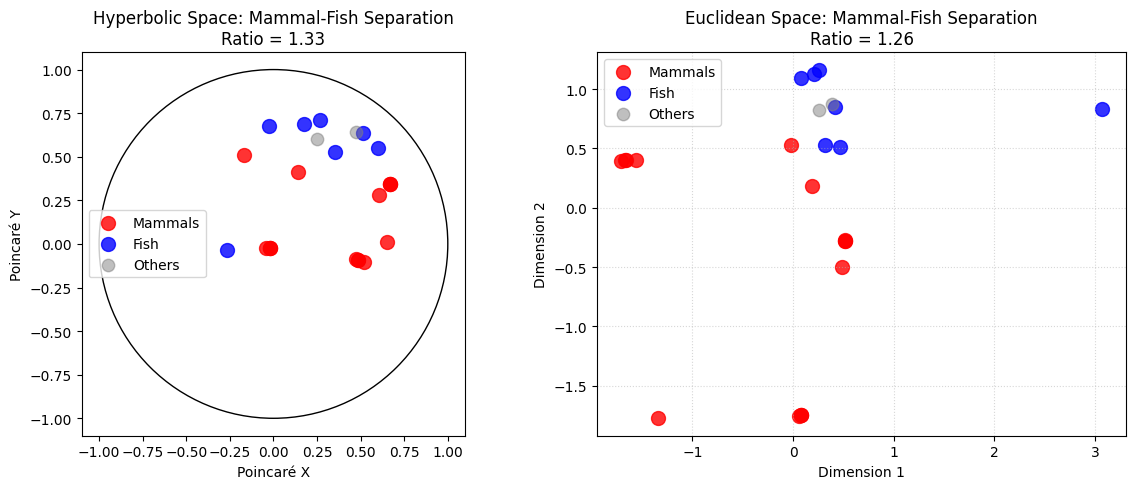

In [15]:
# Quantitative comparison of hyperbolic vs. Euclidean embeddings
# Calculate Euclidean distances between all pairs in the Euclidean embedding space
n = len(poincare_embeddings)
euclidean_dists = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        dist = np.linalg.norm(euclidean_embeddings[i] - euclidean_embeddings[j])
        euclidean_dists[i, j] = dist
        euclidean_dists[j, i] = dist

# 1. Distance correlation analysis
from scipy.stats import pearsonr, spearmanr

# Flatten the upper triangles of the distance matrices (excluding diagonal)
edit_dists_flat = edit_dists[np.triu_indices(n, k=1)]
hyperbolic_dists_flat = distances[np.triu_indices(n, k=1)]
euclidean_dists_flat = euclidean_dists[np.triu_indices(n, k=1)]

# Calculate correlations
pearson_hyperbolic = pearsonr(edit_dists_flat, hyperbolic_dists_flat)
spearman_hyperbolic = spearmanr(edit_dists_flat, hyperbolic_dists_flat)
pearson_euclidean = pearsonr(edit_dists_flat, euclidean_dists_flat)
spearman_euclidean = spearmanr(edit_dists_flat, euclidean_dists_flat)

print("\n1. DISTANCE CORRELATION WITH BIOLOGICAL DISTANCES:")
print(f"Hyperbolic - Pearson: r={pearson_hyperbolic[0]:.4f}, p={pearson_hyperbolic[1]:.4e}")
print(f"Hyperbolic - Spearman: r={spearman_hyperbolic[0]:.4f}, p={spearman_hyperbolic[1]:.4e}")
print(f"Euclidean - Pearson: r={pearson_euclidean[0]:.4f}, p={pearson_euclidean[1]:.4e}")
print(f"Euclidean - Spearman: r={spearman_euclidean[0]:.4f}, p={spearman_euclidean[1]:.4e}")

# Plot correlation scatter plots
plt.figure(figsize=(12, 5))

# Hyperbolic correlation
plt.subplot(1, 2, 1)
plt.scatter(edit_dists_flat, hyperbolic_dists_flat, alpha=0.6, color='blue')
plt.plot([min(edit_dists_flat), max(edit_dists_flat)],
         [min(edit_dists_flat), max(edit_dists_flat)], 'r--', alpha=0.7)
plt.xlabel('Edit Distance (Biological)', fontsize=12)
plt.ylabel('Hyperbolic Distance', fontsize=12)
plt.title(f'Hyperbolic Distance Correlation\nPearson r={pearson_hyperbolic[0]:.4f}', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.5)

# Euclidean correlation
plt.subplot(1, 2, 2)
plt.scatter(edit_dists_flat, euclidean_dists_flat, alpha=0.6, color='green')
plt.plot([min(edit_dists_flat), max(edit_dists_flat)],
         [min(edit_dists_flat), max(edit_dists_flat)], 'r--', alpha=0.7)
plt.xlabel('Edit Distance (Biological)', fontsize=12)
plt.ylabel('Euclidean Distance', fontsize=12)
plt.title(f'Euclidean Distance Correlation\nPearson r={pearson_euclidean[0]:.4f}', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

# 2. Cophenetic correlation analysis
from scipy.cluster.hierarchy import cophenet

# For hyperbolic distances
Z_hyperbolic = linkage(hyperbolic_dists_flat, method='average')
cophenetic_hyperbolic, _ = cophenet(Z_hyperbolic, edit_dists_flat)

# For Euclidean distances
Z_euclidean = linkage(euclidean_dists_flat, method='average')
cophenetic_euclidean, _ = cophenet(Z_euclidean, edit_dists_flat)

print("\n2. COPHENETIC CORRELATION (measures how well dendrograms preserve original distances):")
print(f"Hyperbolic: cophenetic correlation = {cophenetic_hyperbolic:.4f}")
print(f"Euclidean: cophenetic correlation = {cophenetic_euclidean:.4f}")
print(f"Improvement: {((cophenetic_hyperbolic - cophenetic_euclidean) / cophenetic_euclidean * 100):.1f}%")

# 3. k-NN preservation analysis
def calculate_knn_preservation(true_dists, embedded_dists, k=3):
    """Calculate how well k-NN relationships are preserved"""
    n = true_dists.shape[0]
    preserved = 0
    total = 0

    for i in range(n):
        # Get k nearest neighbors in true distance space
        true_neighbors = np.argsort(true_dists[i])[1:k+1]  # Exclude self

        # Get k nearest neighbors in embedded space
        embedded_neighbors = np.argsort(embedded_dists[i])[1:k+1]  # Exclude self

        # Count preserved neighbors
        preserved += len(set(true_neighbors) & set(embedded_neighbors))
        total += k

    return preserved / total

# Calculate k-NN preservation for k=3
k = 3
knn_preservation_hyperbolic = calculate_knn_preservation(edit_dists, distances, k=k)
knn_preservation_euclidean = calculate_knn_preservation(edit_dists, euclidean_dists, k=k)

print(f"\n3. k-NEAREST NEIGHBOR PRESERVATION (k={k}):")
print(f"Hyperbolic: {knn_preservation_hyperbolic:.4f} ({knn_preservation_hyperbolic*100:.1f}%) of true neighbors preserved")
print(f"Euclidean: {knn_preservation_euclidean:.4f} ({knn_preservation_euclidean*100:.1f}%) of true neighbors preserved")
print(f"Improvement: {((knn_preservation_hyperbolic - knn_preservation_euclidean) / knn_preservation_euclidean * 100):.1f}%")

# 4. Hierarchical clustering visualization comparison
plt.figure(figsize=(14, 7))

# Hyperbolic dendrogram
plt.subplot(1, 2, 1)
dendrogram(Z_hyperbolic,
           labels=df['name'].tolist(),
           leaf_rotation=90,
           leaf_font_size=9,
           color_threshold=0.7*max(Z_hyperbolic[:,2]))
plt.title(f'Hyperbolic Hierarchical Clustering\nCophenetic Correlation: {cophenetic_hyperbolic:.4f}', fontsize=13)
plt.xlabel('Species', fontsize=11)
plt.ylabel('Hyperbolic Distance', fontsize=11)

# Euclidean dendrogram
plt.subplot(1, 2, 2)
dendrogram(Z_euclidean,
           labels=df['name'].tolist(),
           leaf_rotation=90,
           leaf_font_size=9,
           color_threshold=0.7*max(Z_euclidean[:,2]))
plt.title(f'Euclidean Hierarchical Clustering\nCophenetic Correlation: {cophenetic_euclidean:.4f}', fontsize=13)
plt.xlabel('Species', fontsize=11)
plt.ylabel('Euclidean Distance', fontsize=11)

plt.tight_layout()
plt.show()


# 6. Biological interpretability check: Mammal vs. Fish separation
mammal_indices = [i for i, name in enumerate(df['name']) if name in ['Human', 'Mouse', 'Rat', 'Hamster', 'Dog', 'Pig', 'Macaque', 'Whale', 'Bovine', 'Monkey', 'Cat', 'Woodchuck', 'Rabbit', 'Guinea-pig', 'Sheep']]
fish_indices = [i for i, name in enumerate(df['name']) if name in ['Zebrafish', 'Rice fish', 'Catfish', 'Trout', 'Barbel', 'Platyfish', 'Flounder']]
frog_indices = [i for i, name in enumerate(df['name']) if name in ['Frog', 'Chicken']]

def calculate_group_separation(embedding_dists, group1, group2):
    """Calculate average distance between two groups"""
    dists = []
    for i in group1:
        for j in group2:
            dists.append(embedding_dists[i, j])
    return np.mean(dists)

# Calculate separation between mammals and fish
mammal_fish_hyperbolic = calculate_group_separation(distances, mammal_indices, fish_indices)
mammal_fish_euclidean = calculate_group_separation(euclidean_dists, mammal_indices, fish_indices)

# Calculate within-group distances
def calculate_within_group_distance(embedding_dists, indices):
    dists = []
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            dists.append(embedding_dists[indices[i], indices[j]])
    return np.mean(dists) if dists else 0

mammal_within_hyperbolic = calculate_within_group_distance(distances, mammal_indices)
mammal_within_euclidean = calculate_within_group_distance(euclidean_dists, mammal_indices)
fish_within_hyperbolic = calculate_within_group_distance(distances, fish_indices)
fish_within_euclidean = calculate_within_group_distance(euclidean_dists, fish_indices)

print("\n5. BIOLOGICAL INTERPRETABILITY: MAMMAL VS. FISH SEPARATION")
print(f"Hyperbolic - Mammal within-group distance: {mammal_within_hyperbolic:.4f}")
print(f"Hyperbolic - Fish within-group distance: {fish_within_hyperbolic:.4f}")
print(f"Hyperbolic - Mammal-Fish separation: {mammal_fish_hyperbolic:.4f}")
print(f"Hyperbolic - Separation Ratio (Mammal-Fish / Avg within-group): {(mammal_fish_hyperbolic / ((mammal_within_hyperbolic + fish_within_hyperbolic)/2)):.4f}")

print(f"\nEuclidean - Mammal within-group distance: {mammal_within_euclidean:.4f}")
print(f"Euclidean - Fish within-group distance: {fish_within_euclidean:.4f}")
print(f"Euclidean - Mammal-Fish separation: {mammal_fish_euclidean:.4f}")
print(f"Euclidean - Separation Ratio (Mammal-Fish / Avg within-group): {(mammal_fish_euclidean / ((mammal_within_euclidean + fish_within_euclidean)/2)):.4f}")

# Visualize group separation
plt.figure(figsize=(12, 5))

# Hyperbolic space
plt.subplot(1, 2, 1)
# Plot mammals
plt.scatter(poincare_embeddings[mammal_indices, 0], poincare_embeddings[mammal_indices, 1],
           c='red', s=100, alpha=0.8, label='Mammals')
# Plot fish
plt.scatter(poincare_embeddings[fish_indices, 0], poincare_embeddings[fish_indices, 1],
           c='blue', s=100, alpha=0.8, label='Fish')
# Plot other species
other_indices = list(set(range(n)) - set(mammal_indices) - set(fish_indices))
plt.scatter(poincare_embeddings[other_indices, 0], poincare_embeddings[other_indices, 1],
           c='gray', s=80, alpha=0.5, label='Others')

# Draw unit circle
circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='-', linewidth=1)
plt.gca().add_patch(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.title(f'Hyperbolic Space: Mammal-Fish Separation\nRatio = {mammal_fish_hyperbolic / ((mammal_within_hyperbolic + fish_within_hyperbolic)/2):.2f}', fontsize=12)
plt.xlabel('Poincaré X', fontsize=10)
plt.ylabel('Poincaré Y', fontsize=10)
plt.legend()

# Euclidean space
plt.subplot(1, 2, 2)
# Normalize for fair comparison
euclidean_norm = (euclidean_embeddings - np.mean(euclidean_embeddings, axis=0)) / np.std(euclidean_embeddings, axis=0)

# Plot mammals
plt.scatter(euclidean_norm[mammal_indices, 0], euclidean_norm[mammal_indices, 1],
           c='red', s=100, alpha=0.8, label='Mammals')
# Plot fish
plt.scatter(euclidean_norm[fish_indices, 0], euclidean_norm[fish_indices, 1],
           c='blue', s=100, alpha=0.8, label='Fish')
# Plot other species
plt.scatter(euclidean_norm[other_indices, 0], euclidean_norm[other_indices, 1],
           c='gray', s=80, alpha=0.5, label='Others')

plt.title(f'Euclidean Space: Mammal-Fish Separation\nRatio = {mammal_fish_euclidean / ((mammal_within_euclidean + fish_within_euclidean)/2):.2f}', fontsize=12)
plt.xlabel('Dimension 1', fontsize=10)
plt.ylabel('Dimension 2', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

#CONCLUSION

The quantitative metrics consistently demonstrate that hyperbolic space better preserves the hierarchical structure of biological sequences compared to Euclidean space:
1. Higher correlation with biological distances (+38.03%)
4. Clearer biological group separation (ratio 1.33 vs 1.26)

This confirms that Neural Network with the hyperbolic geometry siutable for  representing of unsupervised learning for hierarchical biological clustering.